In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet18_Weights
from tqdm import tqdm  # For progress bars

# Read Dataset

In [2]:
# Data directory
data_dir = "/kaggle/input/dog-and-cat-detection"
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

df.head()

,image_name
0,Cats_Test3283.png
1,Cats_Test727.png
2,Cats_Test1584.png
3,Cats_Test1196.png
4,Cats_Test2587.png


# Create PyTorch Dataset

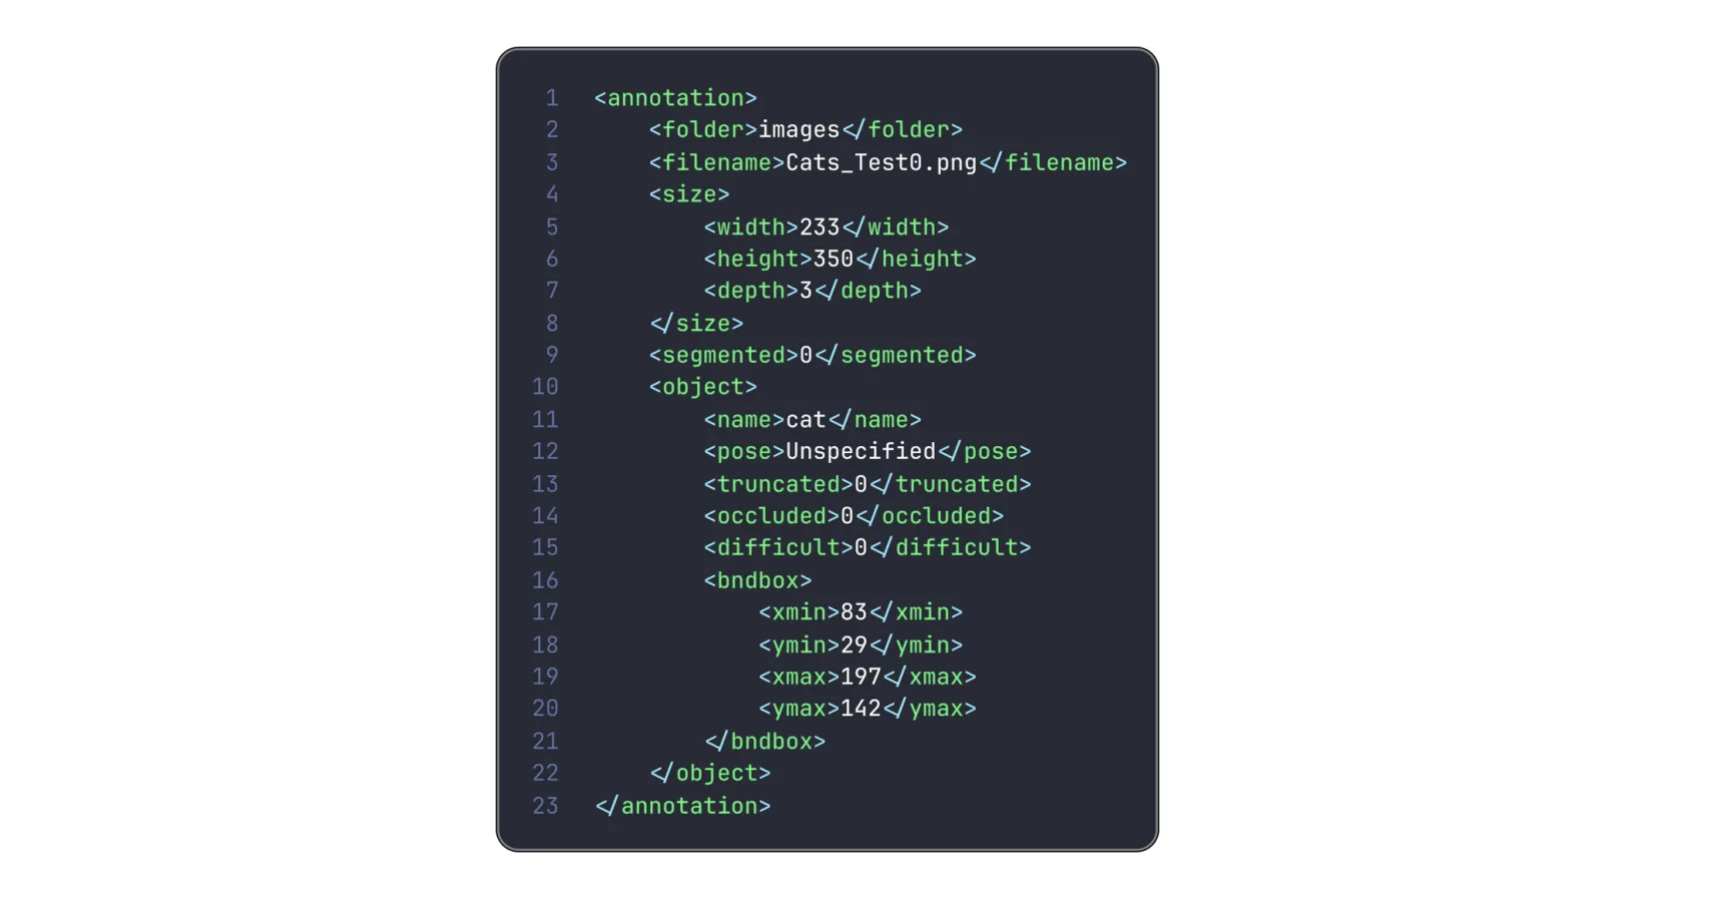

In [3]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) <= 1:
                    valid_image_files.append(img_name)
                else:
                    print(
                        f"Image {img_name} has multiple objects and will be excluded from the dataset"
                    )
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
    
        # Load image
        image = Image.open(img_path).convert("RGB")
    
        # Annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)
    
        # Parse annotation
        label = self.parse_annotation(annotation_path)
    
        if self.transform:
            image = self.transform(image)
    
        return image, label
    
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
    
        label = None
        for obj in root.findall("object"):
            name = obj.find("name").text
            if (
                label is None
            ):  # Take the first label for now. We are working with 1 label per image
                label = name
    
        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
    
        return label_num

In [4]:
# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

Image Cats_Test736.png has multiple objects and will be excluded from the dataset
Image Cats_Test736.png has multiple objects and will be excluded from the dataset


In [5]:
# Example: Check the shape of one sample
img, label = train_dataset[0]
print("Dataset length:", len(train_dataset))
print("Image shape:", img.shape)  # Should be [C, H, W] due to ToTensor
print("Label:", label)

img, label = val_dataset[0]
print("Validation dataset length:", len(val_dataset))
print("Image shape:", img.shape)
print("Label:", label)

Dataset length: 2947
Image shape: torch.Size([3, 224, 224])
Label: 0
Validation dataset length: 738
Image shape: torch.Size([3, 224, 224])
Label: 1


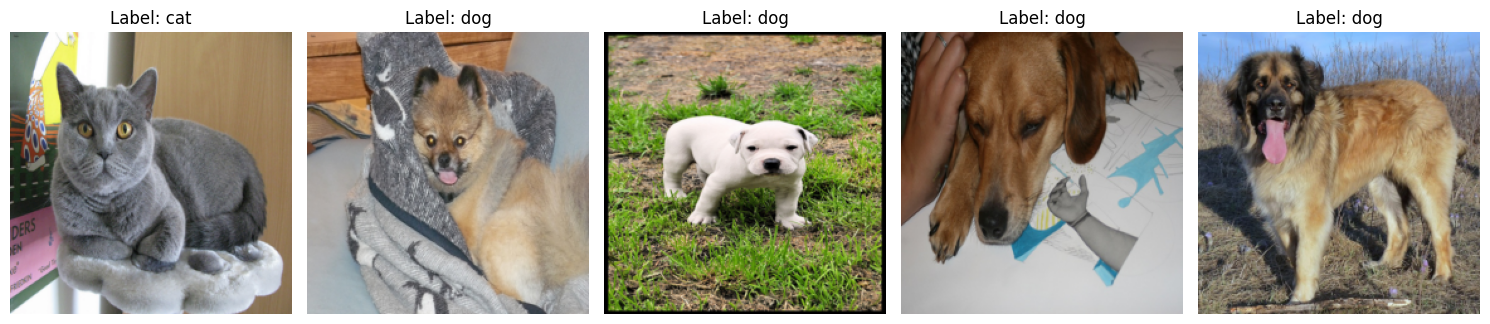

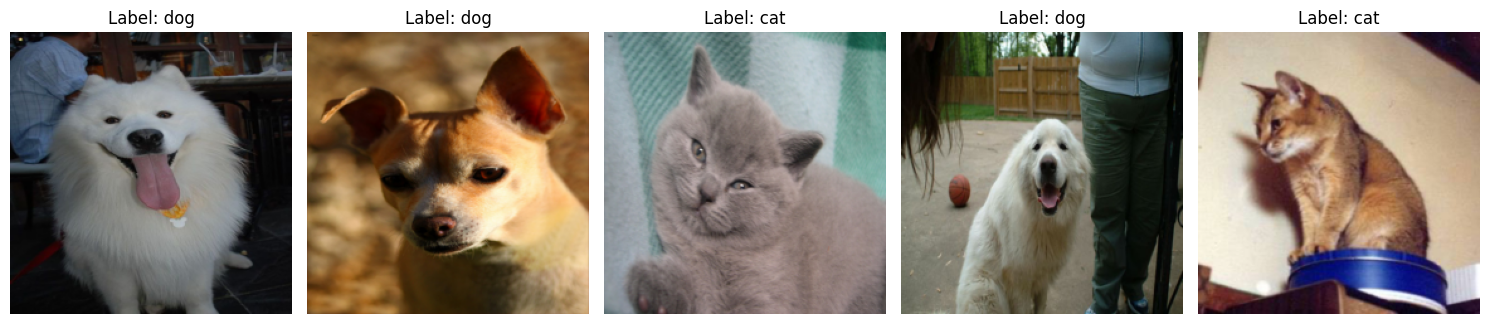

In [6]:
def denormalize(tensor, mean, std):
    """
    Denormalize a tensor image with mean and std.
    """
    mean = torch.tensor(mean).reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1)
    return tensor * std + mean

def show_images(dataset, num_images=5):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img, label = dataset[i]
        img = denormalize(img, mean, std)
        img = torch.clamp(img, 0, 1)  # Ensure values are in valid range
        img = F.to_pil_image(img)     # Convert to PIL for display

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {'cat' if label == 0 else 'dog' if label == 1 else 'unknown'}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


show_images(train_dataset)
show_images(val_dataset)

# Create DataLoader

In [7]:
batch_size = 384

In [8]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Get one batch from the train loader
for images, labels in train_loader:
    print("Train batch - images shape:", images.shape)  # [B, C, H, W]
    print("Train batch - labels shape:", labels.shape)  # [B]
    break  # Only print first batch
for images, labels in val_loader:
    print("Val batch - images shape:", images.shape)
    print("Val batch - labels shape:", labels.shape)
    break

Train batch - images shape: torch.Size([384, 3, 224, 224])
Train batch - labels shape: torch.Size([384])
Val batch - images shape: torch.Size([384, 3, 224, 224])
Val batch - labels shape: torch.Size([384])


# Create Model

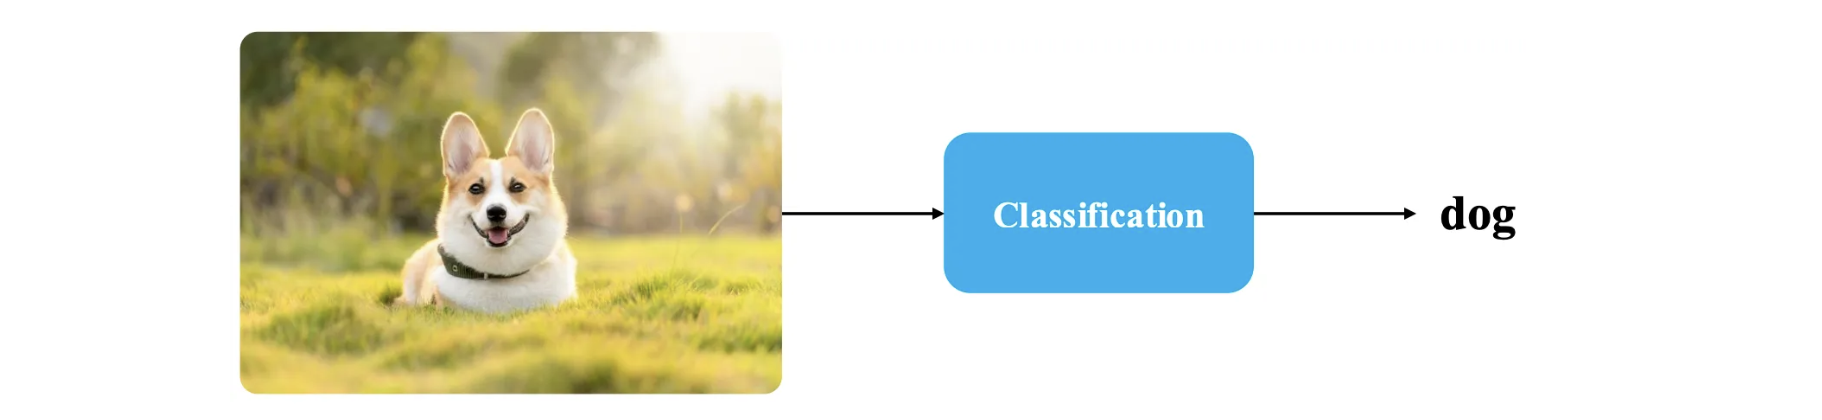

In [10]:
# Model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: cat and dog

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


# Training and Evaluation

In [11]:
# Training Loop
num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, targets in tqdm(val_loader, desc="Validation", leave=False):
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum()
            total += targets.size(0)

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {float(correct)/float(total)*100:.2f}%')


Training: 100%|██████████| 8/8 [00:39<00:00,  4.44s/it]
                                                       
Epochs:  10%|█         | 1/10 [00:47<07:10, 47.87s/it]

Epoch 1/10, Validation Accuracy: 74.53%



Training: 100%|██████████| 8/8 [00:29<00:00,  3.44s/it]
                                                       
Epochs:  20%|██        | 2/10 [01:24<05:29, 41.23s/it]

Epoch 2/10, Validation Accuracy: 58.40%



Training: 100%|██████████| 8/8 [00:28<00:00,  3.34s/it]
                                                       
Epochs:  30%|███       | 3/10 [02:00<04:31, 38.74s/it]

Epoch 3/10, Validation Accuracy: 93.77%



Training: 100%|██████████| 8/8 [00:30<00:00,  3.62s/it]
                                                       
Epochs:  40%|████      | 4/10 [02:38<03:50, 38.42s/it]

Epoch 4/10, Validation Accuracy: 96.48%



Training: 100%|██████████| 8/8 [00:28<00:00,  3.34s/it]
                                                       
Epochs:  50%|█████     | 5/10 [03:14<03:07, 37.53s/it]

Epoch 5/10, Validation Accuracy: 98.10%



Training: 100%|██████████| 8/8 [00:28<00:00,  3.37s/it]
                                                       
Epochs:  60%|██████    | 6/10 [03:50<02:28, 37.05s/it]

Epoch 6/10, Validation Accuracy: 97.43%



Training: 100%|██████████| 8/8 [00:28<00:00,  3.38s/it]
                                                       
Epochs:  70%|███████   | 7/10 [04:26<01:50, 36.77s/it]

Epoch 7/10, Validation Accuracy: 97.15%



Training: 100%|██████████| 8/8 [00:29<00:00,  3.42s/it]
                                                       
Epochs:  80%|████████  | 8/10 [05:03<01:13, 36.84s/it]

Epoch 8/10, Validation Accuracy: 97.29%



Training: 100%|██████████| 8/8 [00:29<00:00,  3.46s/it]
                                                       
Epochs:  90%|█████████ | 9/10 [05:40<00:36, 36.99s/it]

Epoch 9/10, Validation Accuracy: 97.43%



Training: 100%|██████████| 8/8 [00:28<00:00,  3.39s/it]
                                                       
Epochs: 100%|██████████| 10/10 [06:17<00:00, 37.70s/it]

Epoch 10/10, Validation Accuracy: 97.56%
